In [15]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import wandb
import tqdm.notebook as tqdm


## cuda check

In [16]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## WandB login

In [18]:
wandb.login()

True

## EDA

In [19]:
#TODO

# overfitting a single batch

In [20]:
#get one batch of data but in the same label for easier overfitting
overfit_label = 1
num_samples = 1

images_same_label = []

for img, label in trainset:
    if label == overfit_label:
        images_same_label.append(img)
    if len(images_same_label) == num_samples:
        break
        
images_overfit = torch.stack(images_same_label)

images_overfit.shape

torch.Size([8, 3, 32, 32])

## forward process (Noise sheduler)

the goal is to sample an image at a timestamp t and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again. 

In [21]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

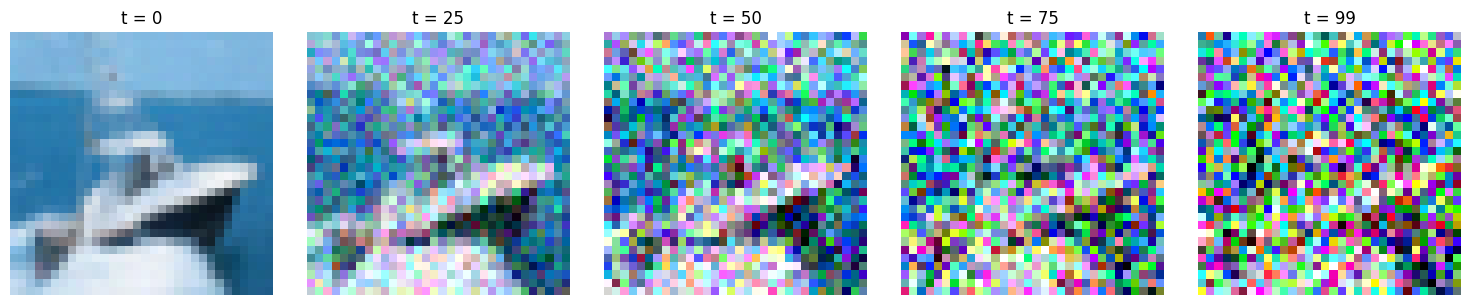

In [22]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = image * 0.5 + 0.5
    # Clamp to [0,1] just to be safe (because of the noise it could happen, that values are slightly outside this range)
    image = image.clamp(0,1)
    # Convert from C,H,W to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu().numpy()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

##Simple Diffusion

In [23]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [24]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [25]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Loss function

In [26]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## sampling

In [27]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    # Sample noise
    img = torch.randn((1, 3, 32, 32), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            img_np = img[0].permute(1,2,0).cpu().numpy()
            img_np = (img_np + 1) / 2.0
            img_np = np.clip(img_np, 0, 1)
            
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.imshow(img_np)
            plt.axis('off')
    
    plt.imshow(img_np)
    plt.axis('off')
            
    plt.show()            

Epoch 0 Loss: 0.8066467046737671
Epoch 5 Loss: 0.8081633448600769
Epoch 10 Loss: 0.7637091875076294


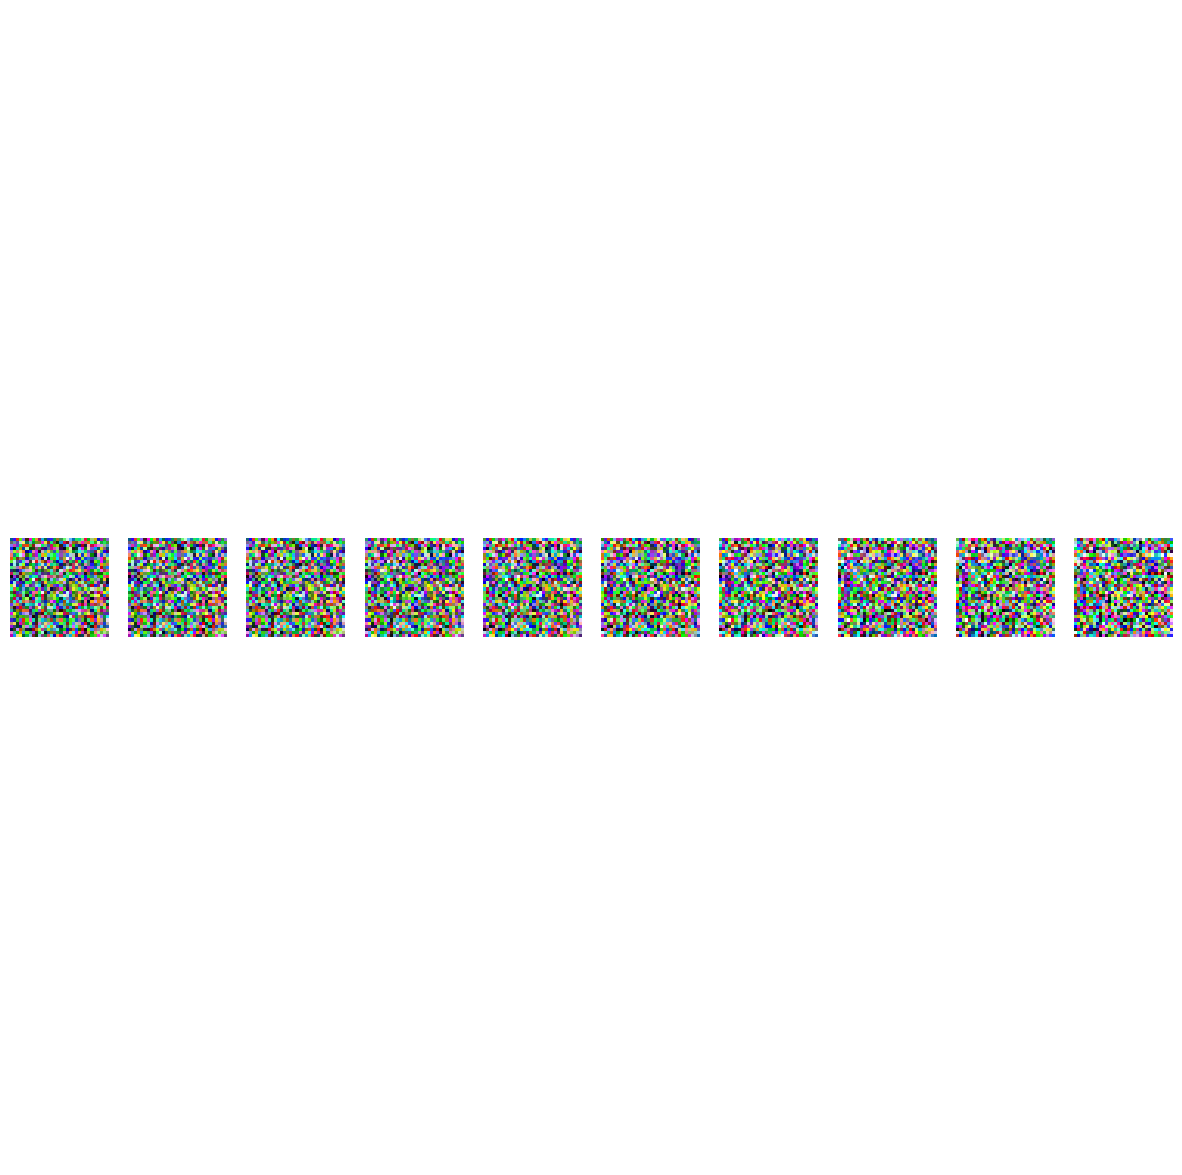

Epoch 15 Loss: 0.7506763339042664
Epoch 20 Loss: 0.7635672092437744
Epoch 25 Loss: 0.7681074142456055
Epoch 30 Loss: 0.7141587138175964
Epoch 35 Loss: 0.695278525352478
Epoch 40 Loss: 0.6668948531150818
Epoch 45 Loss: 0.6698552370071411
Epoch 50 Loss: 0.6268888711929321
Epoch 55 Loss: 0.685905933380127
Epoch 60 Loss: 0.5979440212249756
Epoch 65 Loss: 0.5848839282989502
Epoch 70 Loss: 0.5611509084701538
Epoch 75 Loss: 0.5449998378753662
Epoch 80 Loss: 0.5337843298912048
Epoch 85 Loss: 0.5046584010124207
Epoch 90 Loss: 0.4912116527557373
Epoch 95 Loss: 0.4948204755783081
Epoch 100 Loss: 0.46020323038101196


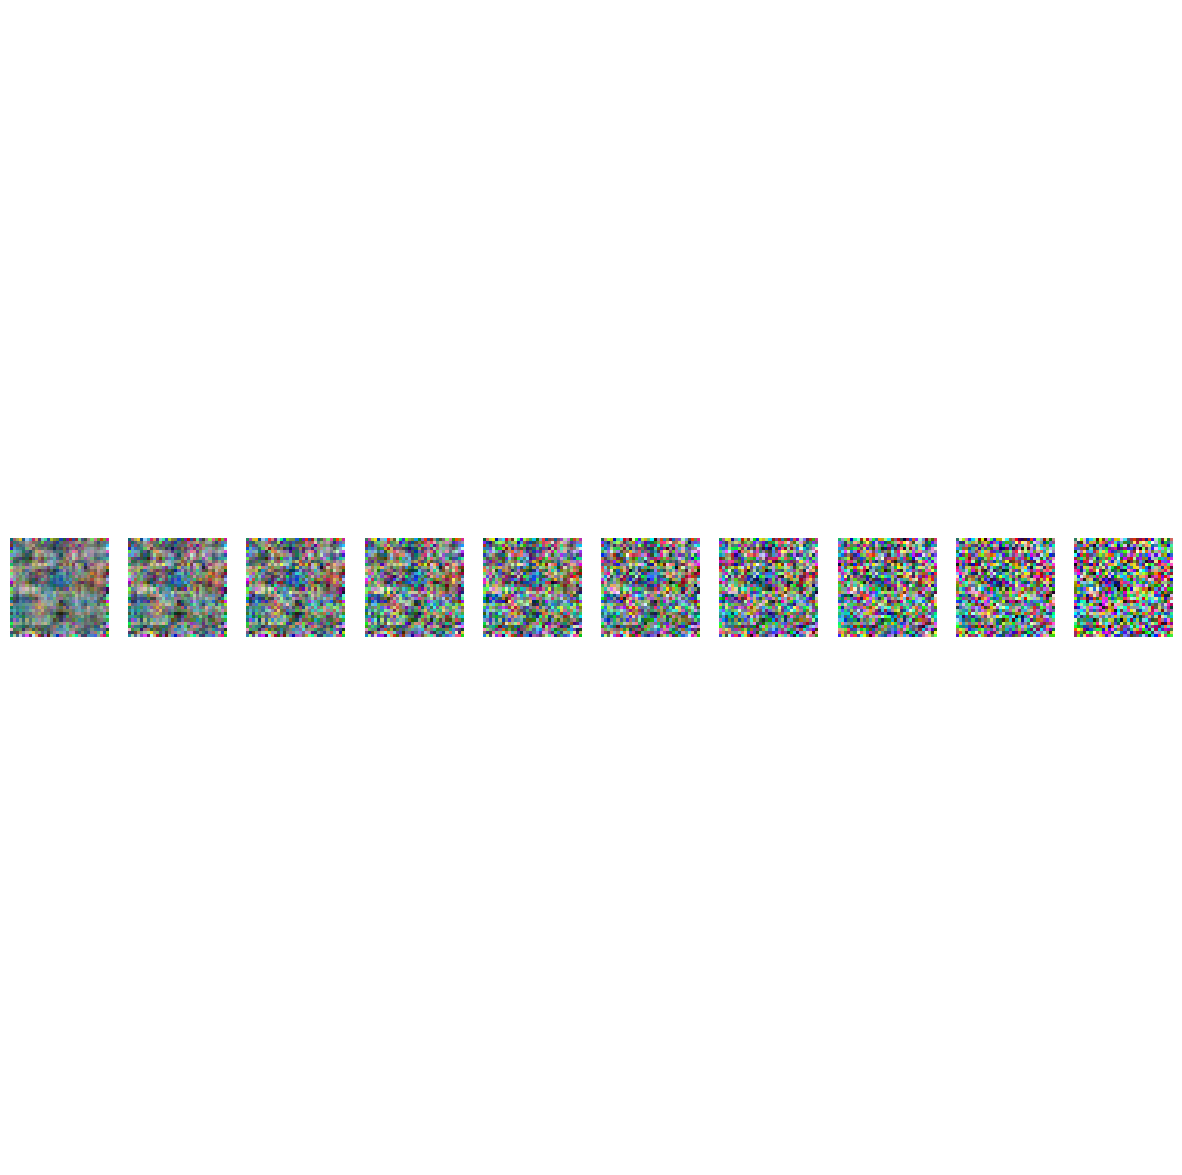

Epoch 105 Loss: 0.49055561423301697
Epoch 110 Loss: 0.43424028158187866
Epoch 115 Loss: 0.654422402381897
Epoch 120 Loss: 0.43032681941986084
Epoch 125 Loss: 0.41459304094314575
Epoch 130 Loss: 0.4086829423904419
Epoch 135 Loss: 0.4057868421077728
Epoch 140 Loss: 0.39968472719192505
Epoch 145 Loss: 0.3931407332420349
Epoch 150 Loss: 0.36629411578178406
Epoch 155 Loss: 0.6917330622673035
Epoch 160 Loss: 0.6456443071365356
Epoch 165 Loss: 0.3508356213569641
Epoch 170 Loss: 0.36595842242240906
Epoch 175 Loss: 0.34412044286727905
Epoch 180 Loss: 0.3343850076198578
Epoch 185 Loss: 0.31929701566696167
Epoch 190 Loss: 0.3185361623764038
Epoch 195 Loss: 0.30890995264053345
Epoch 200 Loss: 0.3093370795249939
Epoch 205 Loss: 0.2939879894256592
Epoch 210 Loss: 0.4136962890625
Epoch 215 Loss: 0.29330968856811523
Epoch 220 Loss: 0.30306750535964966
Epoch 225 Loss: 0.298381507396698
Epoch 230 Loss: 0.271136075258255
Epoch 235 Loss: 0.2677258849143982
Epoch 240 Loss: 0.44076237082481384
Epoch 245 Los

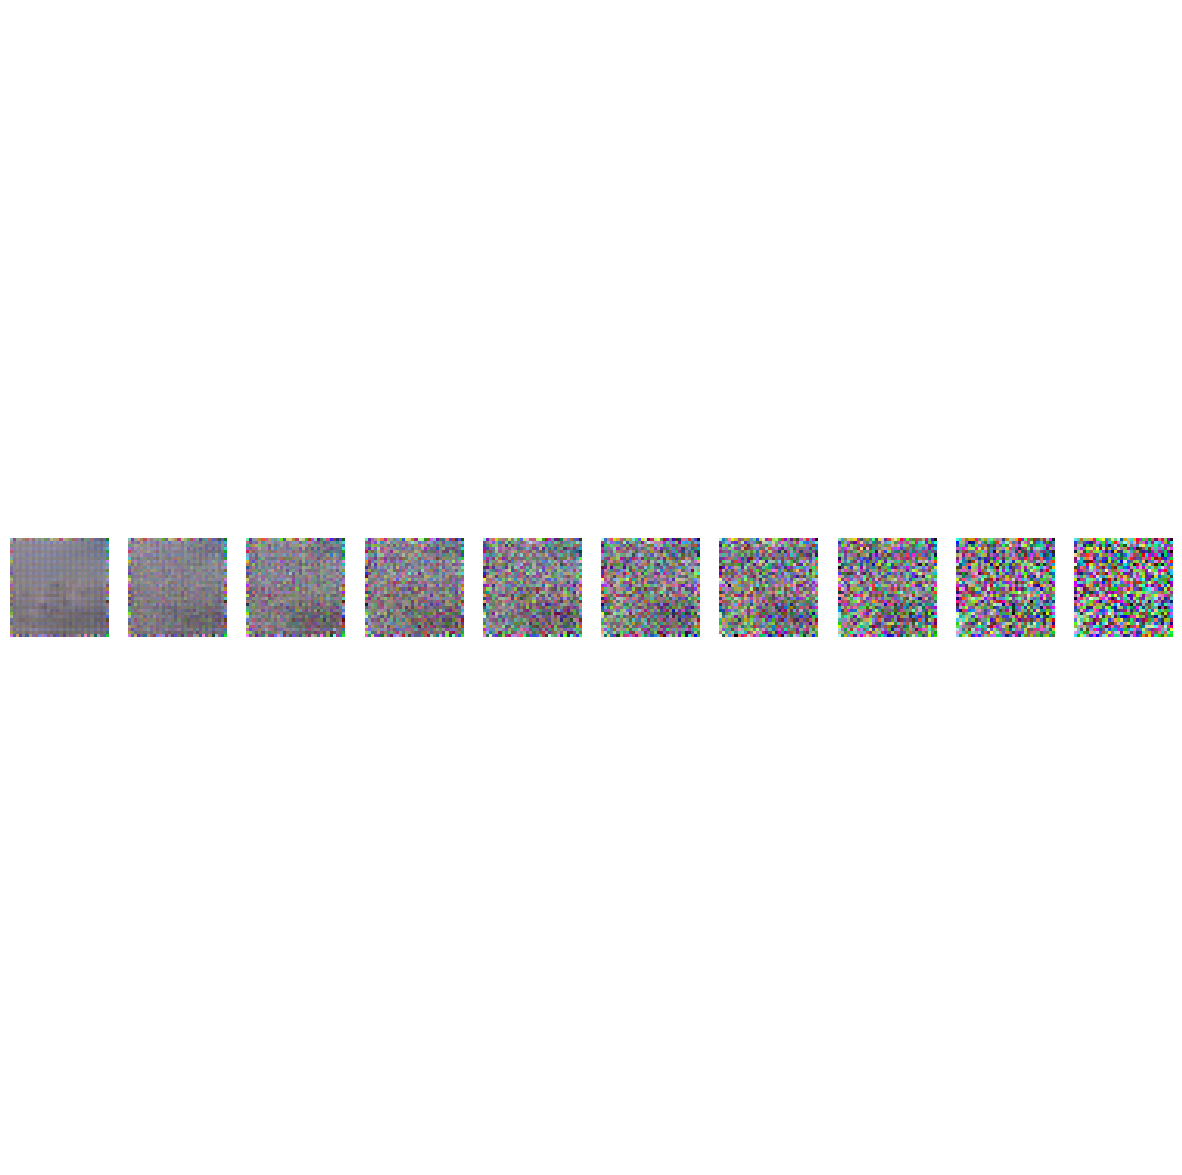

Epoch 505 Loss: 0.1689990758895874
Epoch 510 Loss: 0.1662636548280716
Epoch 515 Loss: 0.2173939198255539
Epoch 520 Loss: 0.16373968124389648
Epoch 525 Loss: 0.16585655510425568
Epoch 530 Loss: 0.16763155162334442
Epoch 535 Loss: 0.168674498796463
Epoch 540 Loss: 0.16862693428993225
Epoch 545 Loss: 0.16930072009563446
Epoch 550 Loss: 0.16795507073402405
Epoch 555 Loss: 0.17103640735149384
Epoch 560 Loss: 0.16449929773807526
Epoch 565 Loss: 0.17204611003398895
Epoch 570 Loss: 0.16636577248573303
Epoch 575 Loss: 0.2003823220729828
Epoch 580 Loss: 0.21744130551815033
Epoch 585 Loss: 0.21278080344200134
Epoch 590 Loss: 0.17902056872844696
Epoch 595 Loss: 0.16728204488754272
Epoch 600 Loss: 0.16141659021377563
Epoch 605 Loss: 0.1649872064590454
Epoch 610 Loss: 0.17187580466270447
Epoch 615 Loss: 0.1581820845603943
Epoch 620 Loss: 0.1565558910369873
Epoch 625 Loss: 0.1954313963651657
Epoch 630 Loss: 0.15812480449676514
Epoch 635 Loss: 0.17728492617607117
Epoch 640 Loss: 0.1574850082397461
Epo

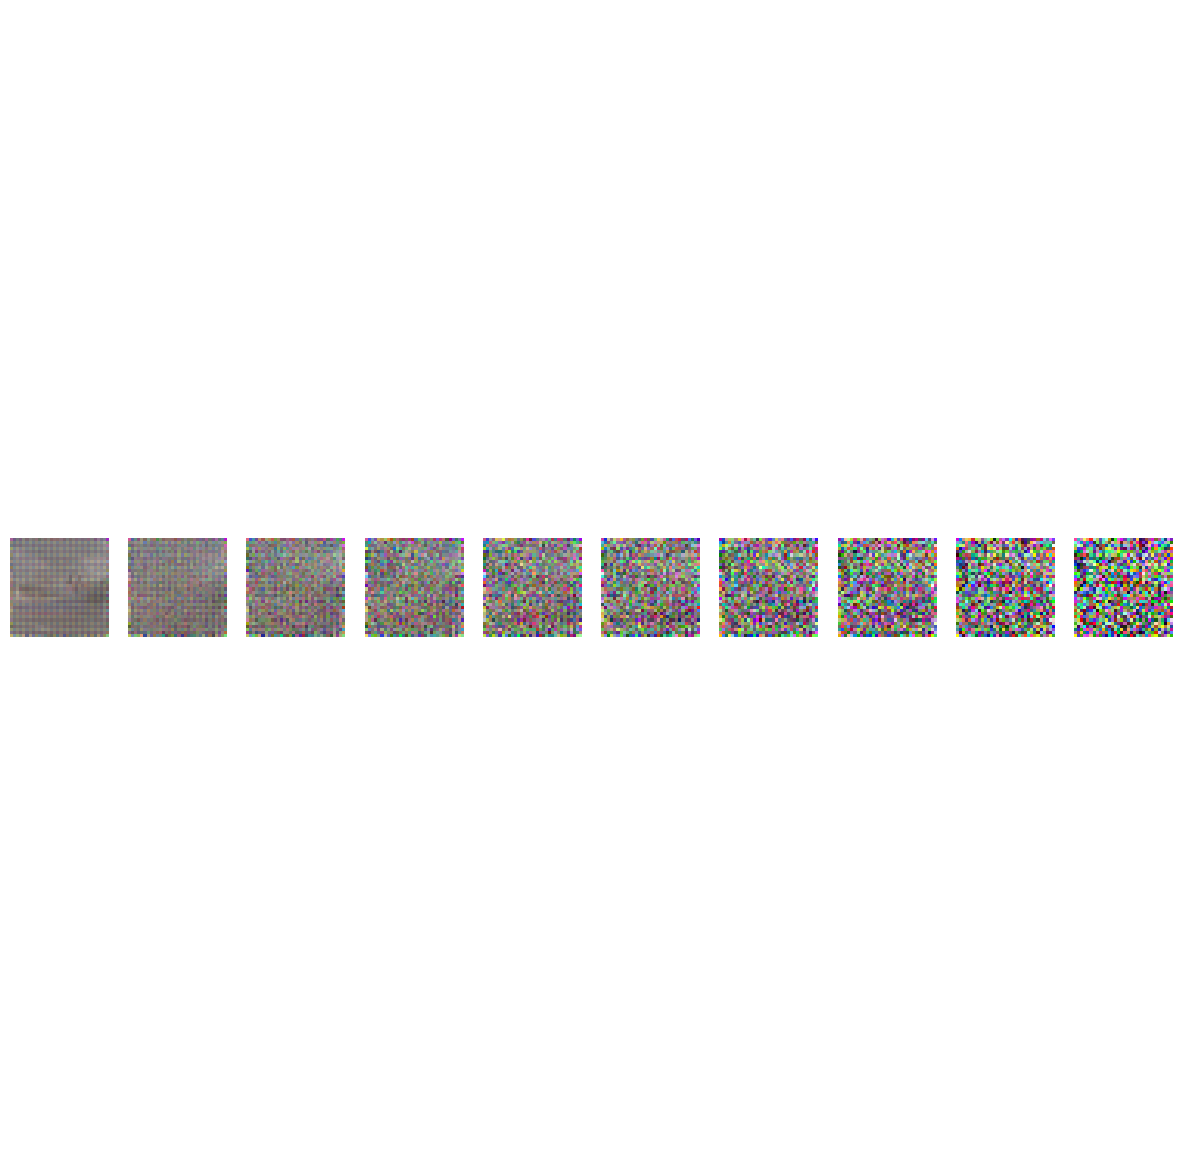

Epoch 1005 Loss: 0.1300906538963318
Epoch 1010 Loss: 0.15598255395889282
Epoch 1015 Loss: 0.1292940080165863
Epoch 1020 Loss: 0.11854007840156555
Epoch 1025 Loss: 0.12414653599262238
Epoch 1030 Loss: 0.13250793516635895
Epoch 1035 Loss: 0.12256018817424774
Epoch 1040 Loss: 0.12503260374069214
Epoch 1045 Loss: 0.18670901656150818
Epoch 1050 Loss: 0.12306025624275208
Epoch 1055 Loss: 0.11721964925527573
Epoch 1060 Loss: 0.17934903502464294
Epoch 1065 Loss: 0.12034676969051361
Epoch 1070 Loss: 0.14947763085365295
Epoch 1075 Loss: 0.14656570553779602
Epoch 1080 Loss: 0.11849578469991684
Epoch 1085 Loss: 0.1895977258682251
Epoch 1090 Loss: 0.11588265001773834
Epoch 1095 Loss: 0.12271343171596527
Epoch 1100 Loss: 0.1279357373714447
Epoch 1105 Loss: 0.14582017064094543
Epoch 1110 Loss: 0.11507157981395721
Epoch 1115 Loss: 0.11843361705541611
Epoch 1120 Loss: 0.11188673228025436
Epoch 1125 Loss: 0.16512003540992737
Epoch 1130 Loss: 0.11955618113279343
Epoch 1135 Loss: 0.3415936827659607
Epoch 

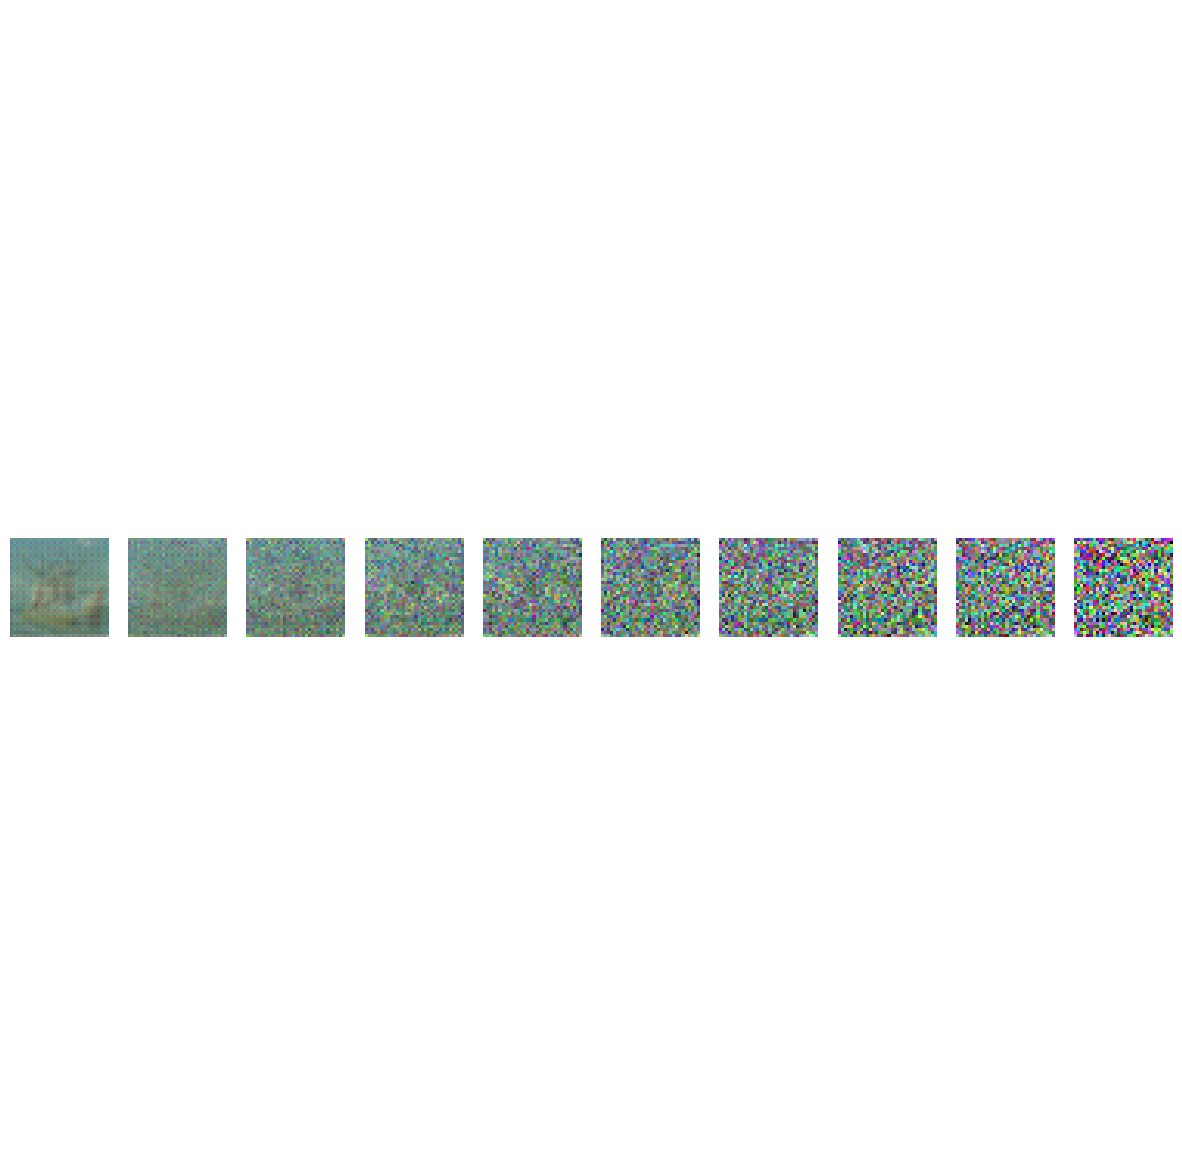

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5000
BATCH_SIZE = 1
T = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        if epoch == 10 or epoch == 100 or epoch == 500 or epoch == 1000 or epoch == 4995:
            sample_plot_image(terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])
        

In [15]:
images_overfit.shape

torch.Size([1, 3, 32, 32])

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling layers
        self.enc1 = (
            nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Upsampling path with skip connections
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
            # Encoder
            x1 = self.enc1(x)
            x2 = self.enc2(F.max_pool2d(x1, 2))
            x3 = self.enc3(F.max_pool2d(x2, 2))
    
            # Decoder with skip connections
            x = F.interpolate(self.dec3(x3), scale_factor=2, mode='nearest') + x2
            x = F.interpolate(self.dec2(x), scale_factor=2, mode='nearest') + x1
            x = self.dec1(x)
            return x

In [ ]:
## Define the diffusion process
class DiffusionModel(nn.Module):
    def __init__(self, model, timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps)  # Linear schedule
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def forward_diffusion(self, x0, t):
        """Apply forward diffusion to add noise to the images."""
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = torch.sqrt(self.alpha_cumprod[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alpha_cumprod[t]).view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def sample(self, x, t):
        """Reverse process: denoise the image step-by-step."""
        for i in reversed(range(t)):
            z = torch.randn_like(x) if i > 0 else 0  # No noise at last step
            x = (1 / torch.sqrt(self.alpha[i])) * (
                x - (1 - self.alpha[i]) / torch.sqrt(1 - self.alpha_cumprod[i]) * self.model(x)
            ) + torch.sqrt(self.beta[i]) * z
        return x

In [ ]:
wandb.init(project="diffusion_overfittest", name= "test", entity="floowbaumgartner")

## Training the model
unet = UNet()
diffusion_model = DiffusionModel(unet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
diffusion_model.to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)

# Loss function tuning
for epoch in range(10_000):
    images = images_overfit.to(device)
    t = torch.randint(0, diffusion_model.timesteps, (images.size(0),), device=device)
    noisy_images, noise = diffusion_model.forward_diffusion(images, t)

    # Predict the noise
    predicted_noise = unet(noisy_images)
    loss = F.mse_loss(predicted_noise, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({"epoch": epoch + 1, "loss": loss.item()})
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

In [ ]:
## Testing and Inference
# Test the forward diffusion process on a single image
sample_image, _ = next(iter(trainloader))
sample_image = sample_image[0].unsqueeze(0).to(device)

# Forward diffusion
timestep = diffusion_model.timesteps - 1
noisy_image, _ = diffusion_model.forward_diffusion(sample_image, timestep)

# Reverse process to generate image
generated_image = diffusion_model.sample(noisy_image, diffusion_model.timesteps)


def show_images(original, noisy, generated):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Denormalize and detach tensors for visualization
    original = original.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5
    noisy = noisy.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5
    generated = generated.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5

    # Clip values to [0, 1] for imshow
    original = np.clip(original, 0, 1)
    noisy = np.clip(noisy, 0, 1)
    generated = np.clip(generated, 0, 1)

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(noisy)
    axes[1].set_title('Noisy Image')
    axes[1].axis('off')

    axes[2].imshow(generated)
    axes[2].set_title('Generated Image')
    axes[2].axis('off')

    plt.show()

show_images(sample_image, noisy_image, generated_image)